#Imports

In [0]:
!pip install --upgrade https://github.com/praw-dev/praw/archive/master.zip
import praw
import math
import pandas as pd
import nltk
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

     - 39.0MB 215kB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for praw: filename=praw-6.4.1.dev0-cp36-none-any.whl size=124301 sha256=c22127445d9d2ac1291f90b9b02590bec1523e28b28b12f8075e00d663a179f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-hct0hv6c/wheels/5f/4a/b1/574031ec9fde90cdb1fbbeaa74043962e8452ebc763752ea79
Successfully built praw
  Found existing installation: praw 6.4.1.dev0
    Uninstalling praw-6.4.1.dev0:
      Successfully uninstalled praw-6.4.1.dev0


For this tutorial, we'll be using a Reddit API wrapper, called `praw`, to loop through the /r/politics subreddit headlines.

To get started with `praw`, you will need to create a Reddit app and obtain your Client ID and Client Secret.

**Make a Reddit app**


1. Log into your reddit account

2. Navigate to https://www.reddit.com/prefs/apps/.
3. Click on the button that says "are you a developer? create an app..."

  *   Enter a name (username works)
  *   Select "script"
  *   Use http://localhost:8080 as a redirect URI



4. Once you click **"create app"**, you'll see where your Client ID and Client Secret are.


To get started, lets create a Reddit Client.
![Create a reddit client](https://drive.google.com/open?id=1fYog73J0poF-CusTuS1WoOGdaYpKfyyV)


In [0]:
reddit = praw.Reddit(client_id='ZeDYpbH-Uauw4Q',
                     client_secret='mzi7iHAaZ73Smw3tlR3q8nSjFkU',
                     user_agent='Fancy')

Define a set of headlines so that we dont get duplicates if we run multiple times.

In [0]:
headlines = set()

Iterate through the /r/machinelearning subreddit using the API client.

In [0]:
from IPython.display import clear_output
clear_output(wait=True)

for submission in reddit.subreddit('machinelearning').hot(limit=None):
  headlines.add(submission.title)
  #display.clear_output()
  #print(headlines)

We iterate over the hot posts in /r/machinelearning, setting the limit to None so we can get up to 1000 headlines.

# Labelling our data

We will use NLTK's built-in Vader Sentiment Analyzer that ranks a piece of text as positive, negative or neutral using a lexicon of positive and negative words. 

We first create a **Sentiment Intensity Analyzer** to categorize our headlines, then we use **polarity_scores** method to get the sentiment.

Then we append each sentiment dictionary to a results list, which we'll transform into a dataframe .

In [0]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in headlines:
  polarity_score = sia.polarity_scores(line)
  polarity_score['headline'] = line
  results.append(polarity_score)

pprint(results[:3], width=100)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[{'compound': 0.6369,
  'headline': '[D] How can I go about learning machine learning to help people with ALS, like '
              'Jason Becker?',
  'neg': 0.0,
  'neu': 0.729,
  'pos': 0.271},
 {'compound': -0.4019,
  'headline': '[R] [1906.10015v1] A Review on Neural Network Models of Schizophrenia and Autism '
              'Spectrum Disorder',
  'neg': 0.184,
  'neu': 0.816,
  'pos': 0.0},
 {'compound': 0.0,
  'headline': '[R] Research Guide for Neural Architecture Search',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0}]


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
dataframe = pd.DataFrame.from_records(results)
dataframe.head()

,compound,headline,neg,neu,pos
0,0.6369,[D] How can I go about learning machine learni...,0.000,0.729,0.271
1,-0.4019,[R] [1906.10015v1] A Review on Neural Network ...,0.184,0.816,0.000
2,0.0000,[R] Research Guide for Neural Architecture Search,0.000,1.000,0.000
3,-0.2960,[Research] Automated deep learning design for ...,0.115,0.885,0.000
4,-0.2732,[D] Do you guys use low level tensorflow or hi...,0.123,0.877,0.000





---


Our dataframe has 4 columns from the scored sentiments: **Neu**, **Neg**, **Pos** and **Compound**. 

The first 3 represent the sentiment score percentage of each sentiment category in our headline, and the **compound** single number scores the sentiment between a range of -1( Extremely Negative) and 1(Extremely Positive).

Here we consider posts with a compound value greater than 0.2 as positive and less than 0.2 as negative. 

### Let us create a positive label of 1 if the **compound** is greater than 0.2, and a label of -1 if **compound** is less than 0.2. 

In [0]:
dataframe['label'] = 0
dataframe.loc[dataframe['compound'] > 0.2, 'label'] = 1
dataframe.loc[dataframe['compound'] < -0.2, 'label'] = -1
dataframe.head()

,compound,headline,neg,neu,pos,label
0,0.6369,[D] How can I go about learning machine learni...,0.000,0.729,0.271,1
1,-0.4019,[R] [1906.10015v1] A Review on Neural Network ...,0.184,0.816,0.000,-1
2,0.0000,[R] Research Guide for Neural Architecture Search,0.000,1.000,0.000,0
3,-0.2960,[Research] Automated deep learning design for ...,0.115,0.885,0.000,-1
4,-0.2732,[D] Do you guys use low level tensorflow or hi...,0.123,0.877,0.000,-1


Now, lets save our data to a csv file.

In [0]:
new_dataframe = dataframe[['headline', 'label']]
new_dataframe.to_csv('reddit_ML_headlines_with_labels.csv', mode = 'a', encoding='utf-8', index=False)

# Dataset Statistics

Lets look at a few positive and negative headlines.

In [0]:
print("Positive headlines:\n")
pprint(list(dataframe[dataframe['label'] ==1].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(dataframe[dataframe['label'] ==-1].headline)[:5], width=200)

Positive headlines:

['[D] How can I go about learning machine learning to help people with ALS, like Jason Becker?',
 '[P] Using protein sequences to make better classifiers in bioinformatics',
 '[R] Work Related to Normalizing Unicode using Computer Vision',
 '[D] What are some promising research directions for model-based RL?',
 '[D] AAAI 2020: is it worth it?']

Negative headlines:

['[R] [1906.10015v1] A Review on Neural Network Models of Schizophrenia and Autism Spectrum Disorder',
 '[Research] Automated deep learning design for medical image classification by health-care professionals with no coding experience: a feasibility study',
 '[D] Do you guys use low level tensorflow or high level Keras to build neural nets?',
 '[Discussion] Wait for a unified company ML platform, and loose at least a year, if not more, before the project moves forward, or go with our own readily available tools, but incur a ton of '
 'technical debt in the process?',
 '[P] Image Manipulation and Classif

### Now let us check how many total positives and negatives we have in our dataset.

In [0]:
print(dataframe.label.value_counts())

print(dataframe.label.value_counts(normalize = True) * 100)

 0    212
 1     74
-1     27
Name: label, dtype: int64
 0    67.731629
 1    23.642173
-1     8.626198
Name: label, dtype: float64


The first line displays the raw value counts of the labels, while the second line displays the percentage with the **normalize** keyword.

**Let's plot a bar chart:**

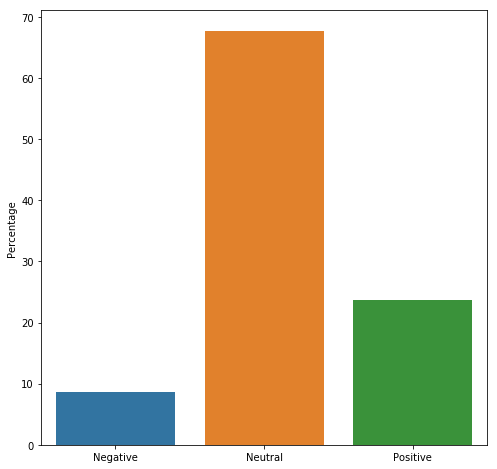

In [0]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = dataframe.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

The large number of neutral headlines to due to some reasons:



1.   We assumed earlier that headlines with compound value between 0.2 and -0.2 are neutral. The higher the margin, the larger the number of neutral headlines. 
2.   We used a general lexicon to categorize machine learning news . The more correct way is to use a machine learning lexicon. The more correct way is to use a political-specific lexicon, but for that we would either need a human to manually label data, or we would need to find a custom lexicon already made.

Another interesting observation is the number of positive headlines, which could be attributed to context of questions. Another possibility is that our analyzer produced a lot of false positives.




#Tokenizers and Stopwords

Now that we have gathered labelled data, lets explore some preprocessing techniques to help us get a cleare understanding of our dataset.

**Tokenization** is the process of breaking a stream of text into smaller units called tokens. 

In our case, our headlines will be considered as sentences and so we will use a word tokenizer.

We create a function that reads a list of headlines and performs lowercasing, tokenization and stop-word removal. 


In [0]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def preprocess_text(headlines):
  tokens = []
  for line in headlines:
    token = tokenizer.tokenize(line)
    token = [t.lower() for t in token if t.lower() not in stop_words]
    tokens.extend(token)
    
  return tokens

# Positive words 
We can get all the positive label headlines from our dataframe, input into our function and use NLTK's `FreqDist` function to get the most common words in the positive headlines

In [0]:
positive_lines = list(dataframe[dataframe.label == 1].headline)

positive_tokens = preprocess_text(positive_lines)
positive_frequency = nltk.FreqDist(positive_tokens)

positive_frequency.most_common(20)

[('learning', 19),
 ('r', 17),
 ('p', 13),
 ('research', 8),
 ('model', 8),
 ('based', 7),
 ('deep', 7),
 ('neural', 7),
 ('machine', 6),
 ('help', 6),
 ('project', 6),
 ('best', 6),
 ('like', 5),
 ('networks', 5),
 ('ml', 5),
 ('using', 4),
 ('vision', 4),
 ('training', 4),
 ('artificial', 4),
 ('intelligence', 4)]

Let us see the frequency of some of the top words in our positive set .



Interestingly, the most positive headline word is 'learning' ! Most likely from **Machine Learning and Deep Learning** .

It is also interesting to see top positive words like ** model, deep, research** . We will also check the negative word section and the most common negative words. 

### Let’s look at more macroscopic side by plotting the frequency distribution and try to examine the pattern of words and not each word specifically.

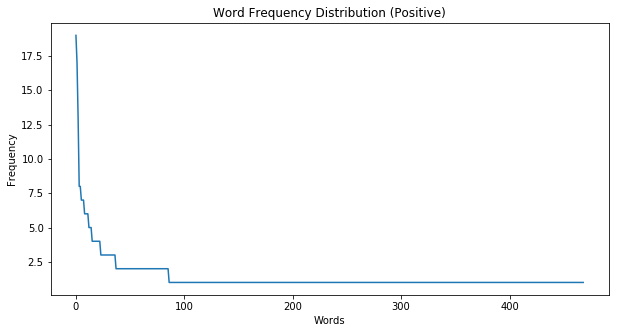

In [0]:
y_val = [x[1] for x in positive_frequency.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title("Word Frequency Distribution (Positive)")
plt.show()

The chart above shows the frequency patterns, the y-axis is the frquency of the words and x-axis is the words ranked by their frequency . So the most frequent word, in our case is "learning" and is plotted at **(1, 74)**

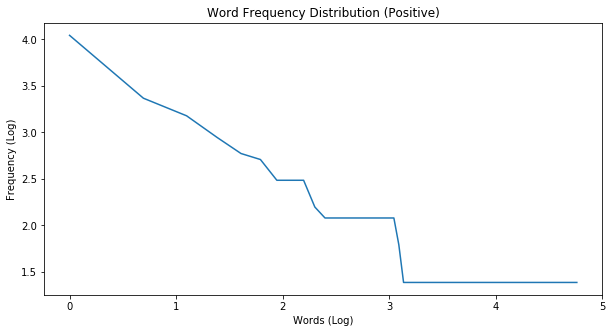

In [0]:
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
  y_final.append(math.log(i + k + z + t))
  
x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

We have an almost straight line with a heavy tail (noisy tail). This shows that our data fits under the Zipf’s Law. 

Zipf's law states that given a large sample of words used, the frequency of any word is inversely proportional to its rank in the frequency table. So word number n has a frequency proportional to 1/n.

Thus the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word. 

The above log plot shows that in our word distribution a vast minority of the words appear the most, while the majority of words appear less.

# Negative Words

After looking at the positive words, lets move over to the negative ones. 

We first get and the negative text data and preprocess it.


In [0]:
negative_lines = list(dataframe[dataframe.label == -1].headline)

negative_tokens = preprocess_text(negative_lines)
negative_frequency = nltk.FreqDist(negative_tokens)

negative_frequency.most_common(20)

[('r', 5),
 ('adversarial', 4),
 ('neural', 3),
 ('image', 3),
 ('classification', 3),
 ('face', 3),
 ('news', 3),
 ('students', 3),
 ('network', 2),
 ('research', 2),
 ('study', 2),
 ('level', 2),
 ('ml', 2),
 ('project', 2),
 ('available', 2),
 ('objects', 2),
 ('attacking', 2),
 ('classifier', 2),
 ('math', 2),
 ('games', 2)]

Some more analysis is needed to pin down the differences to see if we can get more accurate negative words, but for now let's move on to some of the plots for negative word distributions:

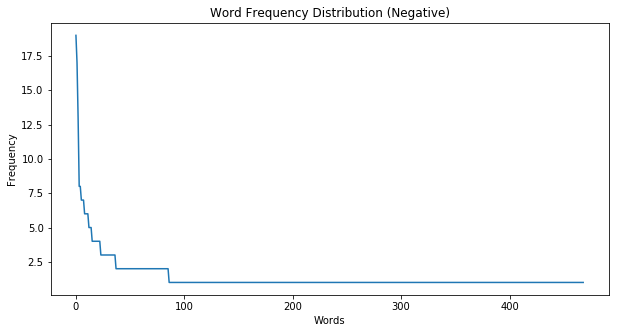

In [0]:
y__val = [x[1] for x in negative_frequency.most_common()]

fig = plt.figure(figsize= (10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

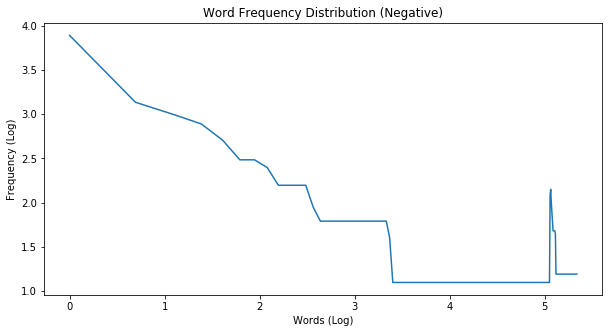

In [0]:
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
  if i + k + z == 0:
    break
  y_final.append(math.log(i + k + z))
  
x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()

### Conclusion

# Assignment 
**Scrape yelp reviews on 5 restaurants in San Francisco and perform the following.**

Write regular expressions for the following: 
1. The set of all alphabetic strings;
2. The set of all lower case alphabetic strings ending in a b;

Perform Sentiment analysis on the reviews. 
